In [1]:
import pandas as pd
import numpy as np


# Cargar los datos desde el archivo Excel
consumos = pd.read_excel("Estadisticas gasolina.xlsx", sheet_name="CONSUMO")
importaciones = pd.read_excel("Estadisticas gasolina.xlsx", sheet_name="IMPORTACION")

# Eliminar filas completamente vacías
consumos = consumos.dropna(how='all')
importaciones = importaciones.dropna(how='all')

# Limpiar los nombres de las columnas
consumos.columns = consumos.columns.str.strip()
importaciones.columns = importaciones.columns.str.strip()

# Convertir la columna 'Fecha' a formato datetime
consumos['Fecha'] = pd.to_datetime(consumos['Fecha'], errors='coerce')
importaciones['Fecha'] = pd.to_datetime(importaciones['Fecha'], errors='coerce')

# Eliminar filas sin fecha válida
consumos = consumos.dropna(subset=['Fecha'])
importaciones = importaciones.dropna(subset=['Fecha'])

# Establecer la columna Fecha como índice
consumos.set_index('Fecha', inplace=True)
importaciones.set_index('Fecha', inplace=True)

# Asegurar que las columnas de consumo sean numéricas
consumos['Gasolina regular'] = pd.to_numeric(consumos['Gasolina regular'], errors='coerce')
consumos['Gasolina superior'] = pd.to_numeric(consumos['Gasolina superior'], errors='coerce')

# Crear las series temporales
gasolina_regular = consumos['Gasolina regular'].dropna()
gasolina_superior = importaciones['Gasolina superior'].dropna()


# Análisis serie temporales: Gasolina Regular


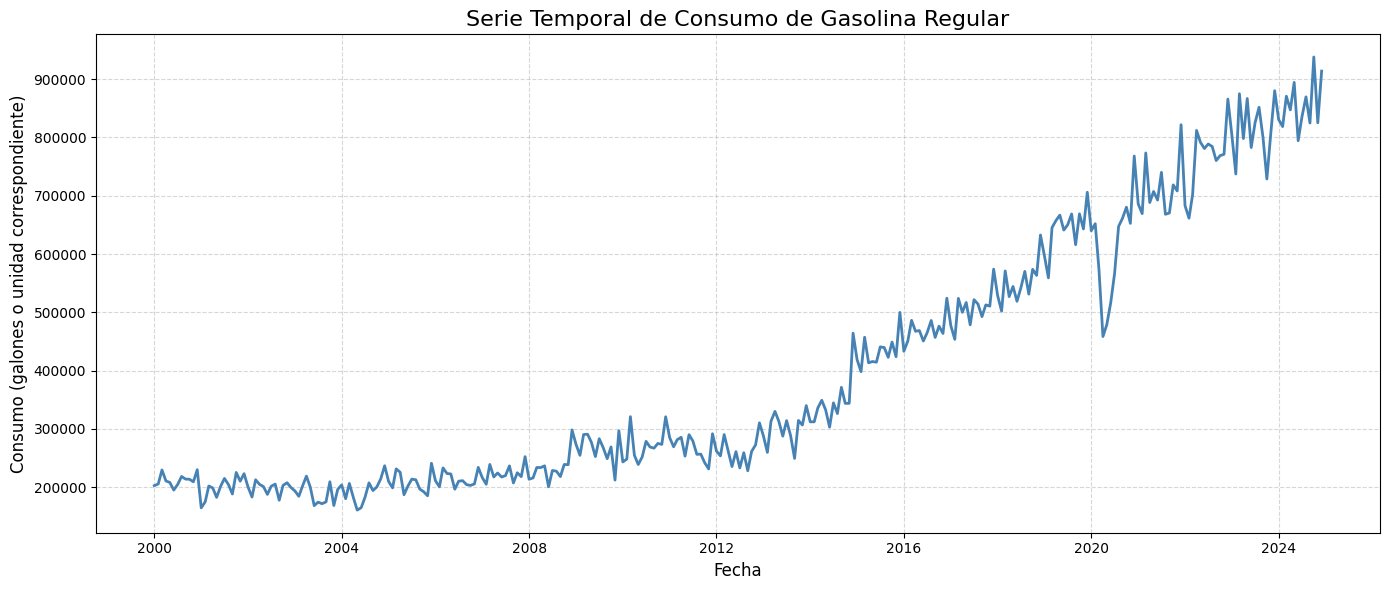

In [2]:
import matplotlib.pyplot as plt

# Configuración del gráfico
plt.figure(figsize=(14, 6))
plt.plot(gasolina_regular, color='steelblue', linewidth=2)

# Títulos y etiquetas
plt.title("Serie Temporal de Consumo de Gasolina Regular", fontsize=16)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Consumo (galones o unidad correspondiente)", fontsize=12)

# Líneas de cuadrícula
plt.grid(True, linestyle='--', alpha=0.5)

# Formato del eje de fechas
plt.tight_layout()
plt.show()

En esta primera gráfica se puede ver la serie de consumo de gasolina a lo largo de los años desde 2000 hasta 2024. Estos muestran una tendencia al alza. Esta a simple vista no parece estacionaria. Sin embargo para no dar una conclusión solamente a partir de esta gráfica, en la gráfica de abajo se realizó también la media y la desviación estándar móvil de la serie.

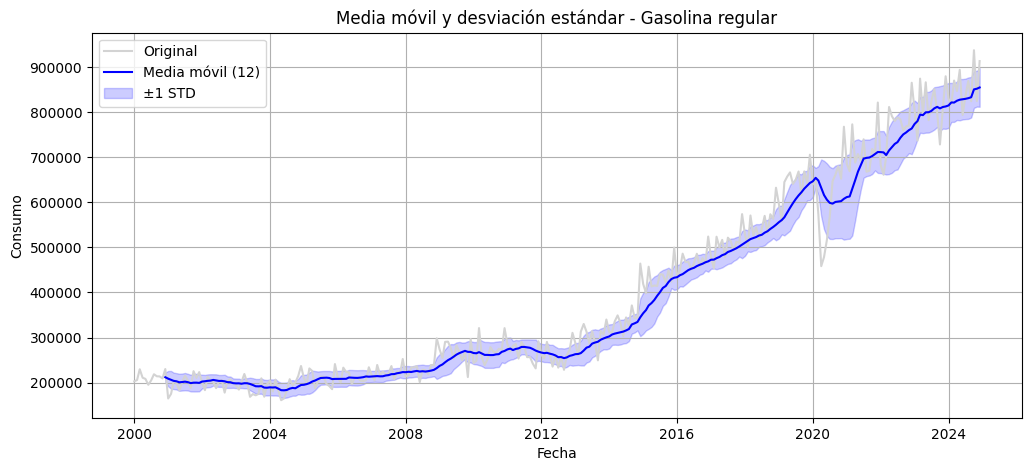

In [3]:
media_movil = gasolina_regular.rolling(window=12).mean()
desviacion_std = gasolina_regular.rolling(window=12).std()

plt.figure(figsize=(12, 5))
plt.plot(gasolina_regular, label='Original', color='lightgray')
plt.plot(media_movil, label='Media móvil (12)', color='blue')
plt.fill_between(gasolina_regular.index,
                 (media_movil - desviacion_std).squeeze(),
                 (media_movil + desviacion_std).squeeze(),
                 color='blue', alpha=0.2, label='±1 STD')

plt.title('Media móvil y desviación estándar - Gasolina regular')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.grid(True)
plt.legend()
plt.show()

en esta gráfica se puede ver tanto una media con tendencia y asi como una desviación estándar que no parece constante a lo largo de los años. Por lo que la serie no es estacionaria y es necesario transformarla. Dado que previamente ya se había realizado este análisis se procede inmediatamente a la transformación de la serie para obtenerla de forma estacionaria. Para ello se aplicó una transformación logarítmica y posteriormente una diferenciación. Además se detectó una estacionalidad entre 12 y 24 meses para esta serie, por lo que será considerado para los modelos.

Tamaño entrenamiento: 230
Tamaño prueba: 58


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


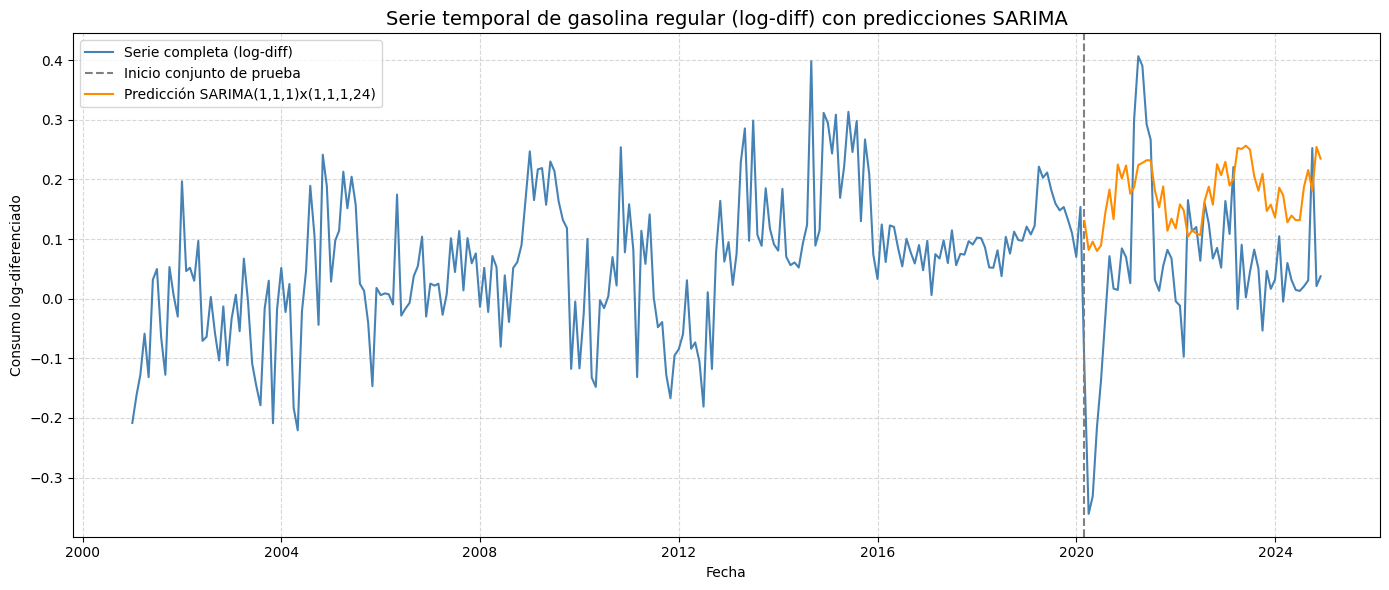

In [10]:
# Transformación logarítmica
gasolina_regular_log = np.log(gasolina_regular)

# Diferenciación estacional (s=12)
gasolina_regular_log_diff = gasolina_regular_log.diff(12).dropna()

# División 80% entrenamiento, 20% prueba
n = len(gasolina_regular_log_diff)
train_size = int(n * 0.8)

train = gasolina_regular_log_diff.iloc[:train_size]
test = gasolina_regular_log_diff.iloc[train_size:]

print(f"Tamaño entrenamiento: {len(train)}")
print(f"Tamaño prueba: {len(test)}")

import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Entrenamiento SARIMA(1,1,1)x(1,1,1,12)
modelo_sarima = SARIMAX(train,
                 order=(1, 1, 1),
                 seasonal_order=(1, 1, 1, 24),
                 enforce_stationarity=False,
                 enforce_invertibility=False)

modelo_sarima_fit = modelo_sarima.fit(disp=False)

# Predicción en el conjunto de prueba
pred = modelo_sarima_fit.predict(start=test.index[0], end=test.index[-1], typ='levels')

# Gráfica de la serie completa con predicciones
plt.figure(figsize=(14, 6))
plt.plot(gasolina_regular_log_diff, label="Serie completa (log-diff)", color='steelblue')
plt.axvline(x=test.index[0], color='gray', linestyle='--', label="Inicio conjunto de prueba")
plt.plot(pred, label="Predicción SARIMA(1,1,1)x(1,1,1,24)", color='darkorange')

plt.title("Serie temporal de gasolina regular (log-diff) con predicciones SARIMA", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Consumo log-diferenciado")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Modelos LSTM para consumos de gasolina regular


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


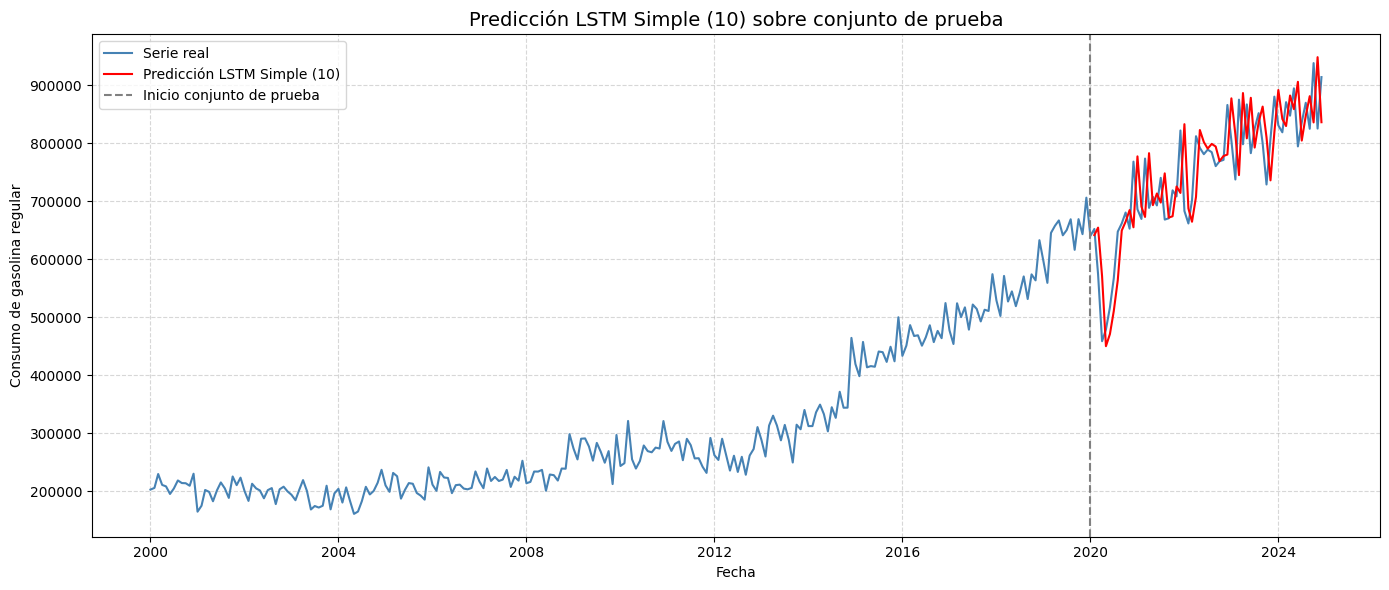

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


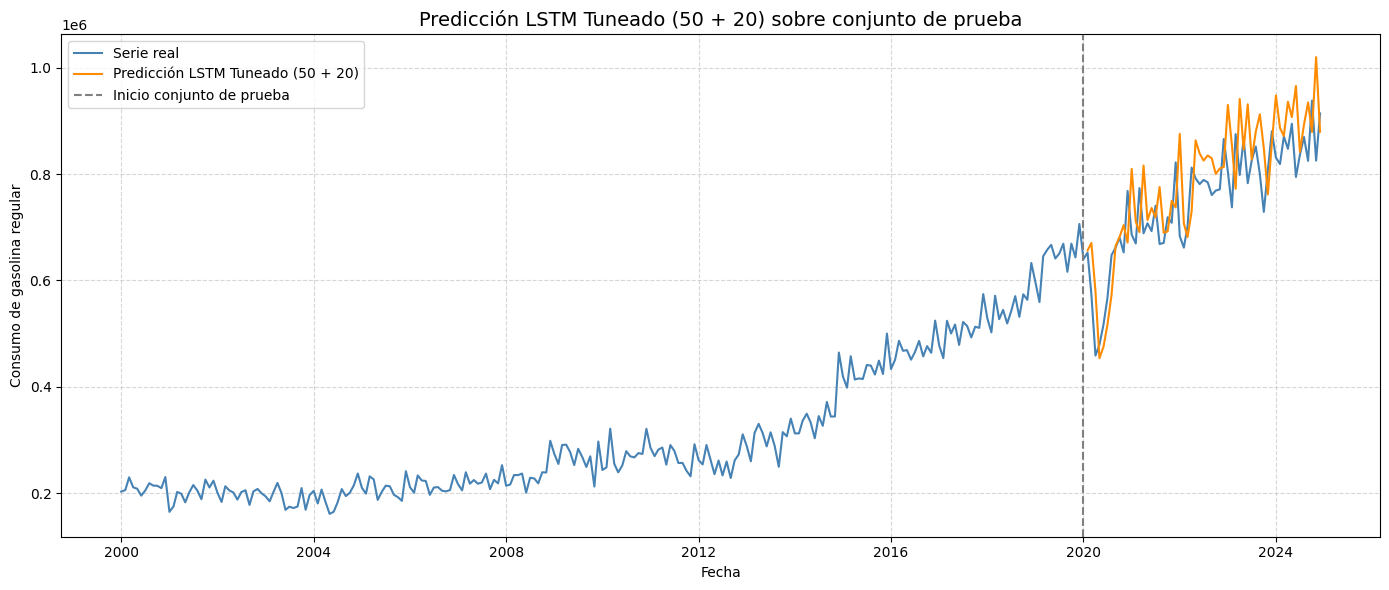

In [14]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Escalar serie ---
scaler = MinMaxScaler()
serie_scaled = scaler.fit_transform(gasolina_regular.values.reshape(-1, 1))

# --- 2. División en entrenamiento y prueba ---
n = len(serie_scaled)
train_size = int(n * 0.8)
lookback = 1

train_scaled = serie_scaled[:train_size]
test_scaled = serie_scaled[train_size:]

def crear_dataset_lstm(datos, lookback=1):
    X, y = [], []
    for i in range(lookback, len(datos)):
        X.append(datos[i - lookback:i])
        y.append(datos[i])
    return np.array(X), np.array(y)

X_train, y_train = crear_dataset_lstm(train_scaled, lookback)
X_test, y_test = crear_dataset_lstm(test_scaled, lookback)
X_train = X_train.reshape((X_train.shape[0], lookback, 1))
X_test = X_test.reshape((X_test.shape[0], lookback, 1))
fechas = gasolina_regular.index
fechas_test = fechas[train_size + lookback:]
y_test_rescaled = scaler.inverse_transform(y_test)

def entrenar_y_graficar(arquitectura, nombre_modelo, color_pred):
    model = Sequential()
    for capa in arquitectura:
        model.add(capa)
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
    
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    
    plt.figure(figsize=(14, 6))
    plt.plot(fechas, gasolina_regular.values, label="Serie real", color='steelblue')
    plt.plot(fechas_test, y_pred_rescaled, label=f"Predicción {nombre_modelo}", color=color_pred)
    plt.axvline(x=fechas[train_size], color='gray', linestyle='--', label="Inicio conjunto de prueba")
    plt.title(f"Predicción {nombre_modelo} sobre conjunto de prueba", fontsize=14)
    plt.xlabel("Fecha")
    plt.ylabel("Consumo de gasolina regular")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# --- 3. Ejecutar ambos modelos por separado ---
entrenar_y_graficar(
    arquitectura=[LSTM(10, input_shape=(lookback, 1)), Dense(1)],
    nombre_modelo="LSTM Simple (10)",
    color_pred="red"
)

entrenar_y_graficar(
    arquitectura=[LSTM(50, return_sequences=True, input_shape=(lookback, 1)), LSTM(20), Dense(1)],
    nombre_modelo="LSTM Tuneado (50 + 20)",
    color_pred="darkorange"
)


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluar_modelo(y_real, y_pred):
    mae = mean_absolute_error(y_real, y_pred)
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    mape = np.mean(np.abs((y_real - y_pred) / y_real)) * 100
    return mae, rmse, mape

# --- Evaluar modelo 1 ---
modelo_1 = Sequential([
    LSTM(10, input_shape=(lookback, 1)),
    Dense(1)
])
modelo_1.compile(optimizer='adam', loss='mean_squared_error')
modelo_1.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
y_pred_1 = modelo_1.predict(X_test)
y_pred_1_rescaled = scaler.inverse_transform(y_pred_1)

# --- Evaluar modelo 2 ---
modelo_2 = Sequential([
    LSTM(50, return_sequences=True, input_shape=(lookback, 1)),
    LSTM(20),
    Dense(1)
])
modelo_2.compile(optimizer='adam', loss='mean_squared_error')
modelo_2.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
y_pred_2 = modelo_2.predict(X_test)
y_pred_2_rescaled = scaler.inverse_transform(y_pred_2)

# --- Calcular métricas ---
mae1, rmse1, mape1 = evaluar_modelo(scaler.inverse_transform(y_test), y_pred_1_rescaled)
mae2, rmse2, mape2 = evaluar_modelo(scaler.inverse_transform(y_test), y_pred_2_rescaled)

# --- Crear tabla comparativa ---
resultados = pd.DataFrame({
    'Modelo': ['LSTM Simple (10)', 'LSTM Tuneado (50+20)'],
    'MAE': [mae1, mae2],
    'RMSE': [rmse1, rmse2],
    'MAPE (%)': [mape1, mape2]
})

# --- Mostrar tabla ordenada por RMSE ---
resultados = resultados.sort_values(by='RMSE')
print(resultados.to_string(index=False))


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
              Modelo          MAE         RMSE  MAPE (%)
    LSTM Simple (10) 58933.953453 71993.268988  7.993915
LSTM Tuneado (50+20) 64518.461653 80465.198627  8.763096
